# STAT3009 Project 1
# SID:1155152095(T = 2095)
# Name: Lam Wai Chiu

## Import package

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

## Load the developed methods

In [25]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

def print_T(t,temp_test_pair,pred_rating):
	print('test_pair:' ,temp_test_pair[t])
	print('pred_rating:',pred_rating[t])

def print_top5(t,temp_test_pair,pred):
	user_index=np.where(temp_test_pair[:,0]==temp_test_pair[t,0])[0]
	item_index=pred_rating[user_index].argsort()[-5:][::-1]
	list1=temp_test_pair[user_index,1][item_index]
	list2=pred_rating[user_index][item_index]
	result = pd.DataFrame(list(zip(list1, list2)), columns =['item', 'rating'])
	print(result.sort_values(by='rating', ascending=False).to_string(index=False))

def get_id(id,temp_id):
	temp=id
	uniq=np.unique(temp_id)
	for i in range(len(id)):
		temp[i]=np.where(id[i]==uniq)[0][0]
	return temp


class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )



In [4]:
# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred

In [5]:
class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

## Process the data

In [6]:
dtrain = pd.read_csv('train.csv', 
			usecols=['user_id', 'item_id', 'rating'])
dtest = pd.read_csv('test.csv', usecols=['user_id', 'item_id'])
sub = pd.read_csv('sample_submission.csv')

## convert string to user_id and item_id -> [user_id, item_id, rating]
# pre-process for training data
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values
# pre-process for testing set
test_pair = dtest[['user_id', 'item_id']].values
temp_test_pair = dtest[['user_id', 'item_id']].values

user_temp=np.append(test_pair[:,0],train_pair[:,0])
item_temp=np.append(test_pair[:,1],train_pair[:,1])

test_pair[:,0]=get_id(test_pair[:,0],user_temp)
test_pair[:,1]=get_id(test_pair[:,1],item_temp)
train_pair[:,0]=get_id(train_pair[:,0],user_temp)
train_pair[:,1]=get_id(train_pair[:,1],item_temp)

n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

## Exploratory data analysis (EDA)
- User rating of the items

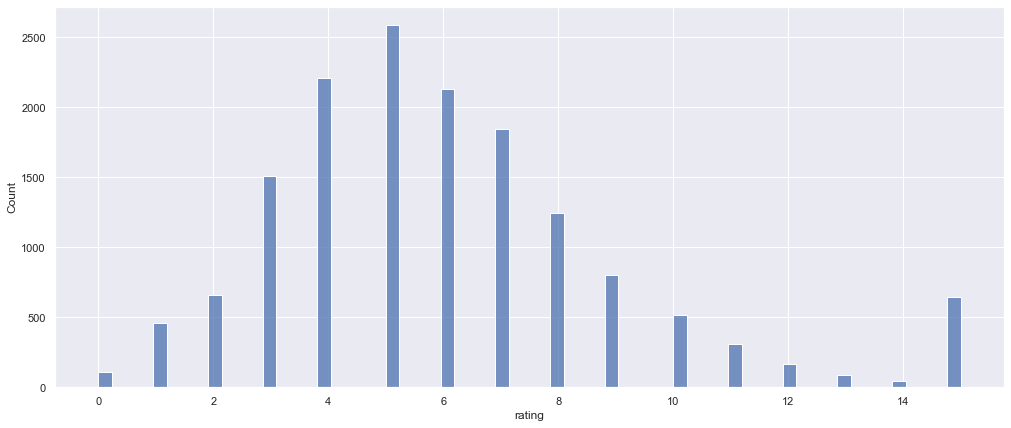

In [75]:
sns.set_theme()
## histograms of rating 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="rating")
plt.show()

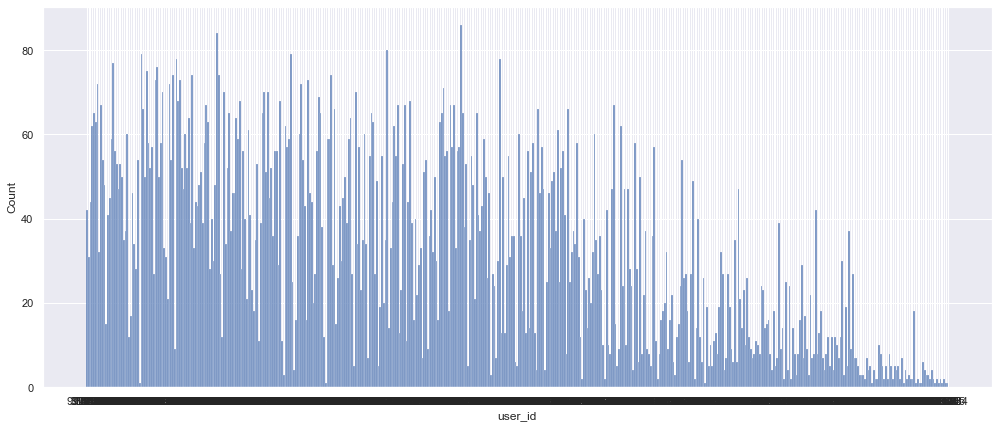

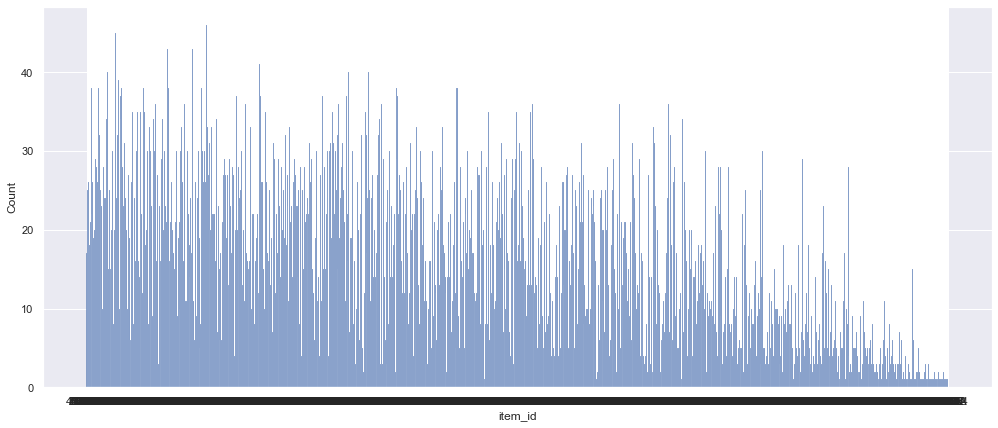

In [74]:
## histograms of user 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="user_id")
plt.show()
## histograms of item 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="item_id")
plt.show()

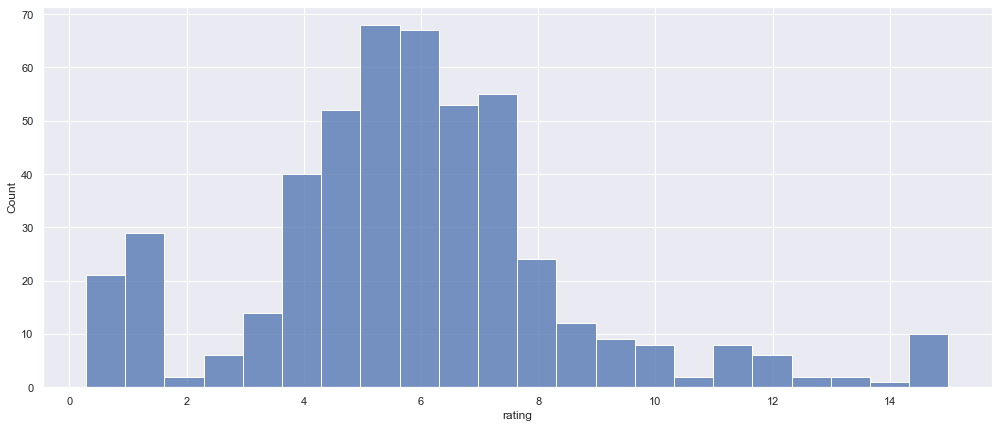

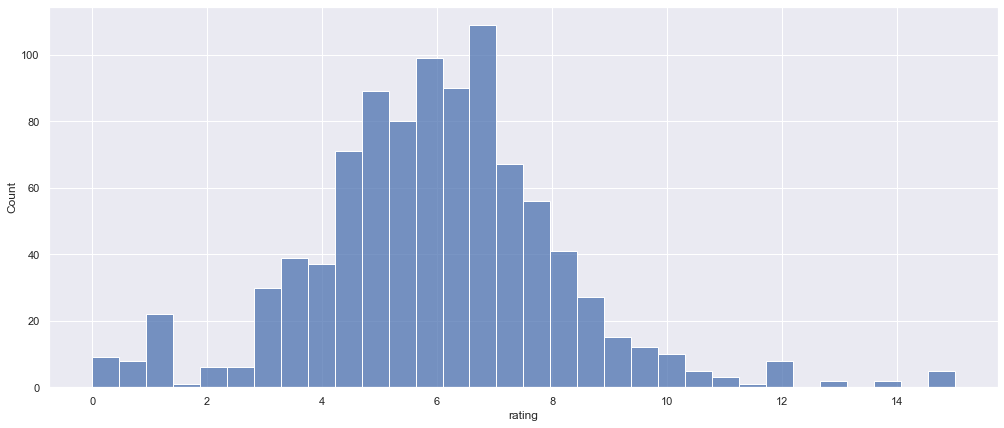

In [73]:
# histgrams for averaged ratings for users/items
plt.figure(1, figsize=(17, 7))
sns.histplot(dtrain.groupby('user_id')['rating'].mean())
plt.show()
plt.figure(1, figsize=(17, 7))
sns.histplot(dtrain.groupby('item_id')['rating'].mean())
plt.show()

In [77]:
## Find Top-20 highest rating items
pd.DataFrame(dtrain.groupby('item_id')['rating'].mean().sort_values(ascending = False)[:20], columns =['rating'])

,rating
item_id,
6CC285,15.000000
12B649,15.000000
984286,15.000000
A34883,15.000000
46615F,15.000000
00A6C3,14.000000
1F195C,14.000000
854152,13.000000
1BD1BC,13.000000


         Count
item_id       
48A3FB      46
C29496      45
248973      43
FEAECC      43
43688C      42
78FEAC      42
5DC14E      41
954956      40
4662D7      40
9BD8B5      40
AFA01C      39
B02D4E      38
52B3D7      38
1FA901      38
1D2EF8      38
1A8CEA      38
9D6BE2      38
EAB8BB      38
93F0A2      38
7DBBE3      38


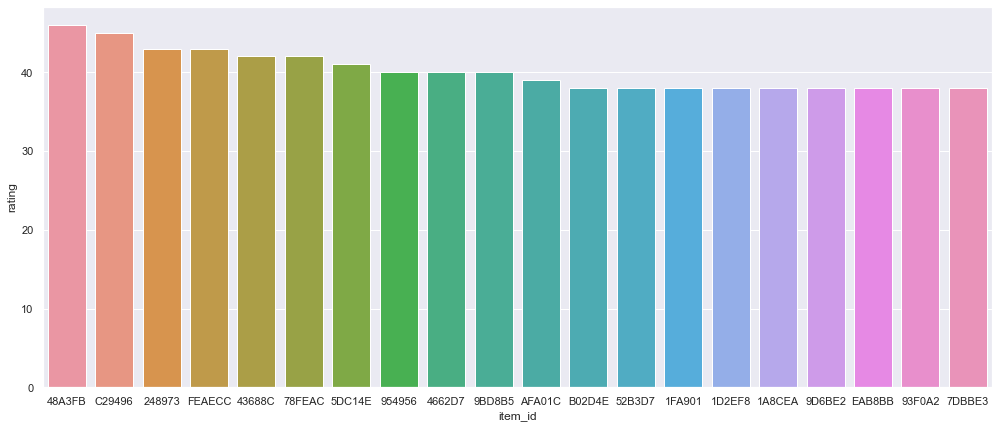

In [69]:
## Find Top-20 most popular items 
dtmp = dtrain.groupby('item_id')['rating'].count().sort_values(ascending = False)[:20]
df=pd.DataFrame(dtrain.groupby('item_id')['rating'].count().sort_values(ascending = False)[:20])
df.columns =['Count']
print(df)
plt.figure(1, figsize=(17, 7))
sns.barplot(x=df.index, y=dtmp, order=dtmp.index)
plt.show()

## Use the developed methods to predict ratings

GLB_LFM

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.098, valid_rmse: 3.715
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.863, valid_rmse: 1.535
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.873, valid_rmse: 1.518
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.958, valid_rmse: 1.822
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.876, valid_rmse: 1.506
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.119, valid_rmse: 1.608
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.109, valid_rmse: 1.601
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.109, valid_rmse: 1.595
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.102, valid_rmse: 1.562
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.113, valid_rmse: 1.572
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.424, valid_rmse: 1.778
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.411, valid_rmse: 1.839
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.431, valid_rmse: 1.772
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.419, valid_rmse: 1.835
5-Fold

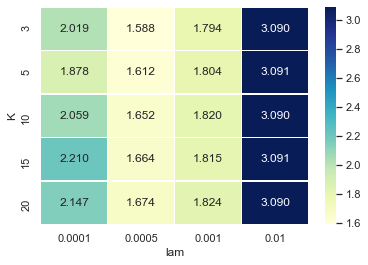

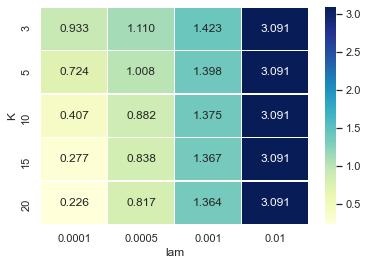

Fitting Reg-LFM: K: 3, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.266 RMSE: 2.602
Reg-LFM: ite: 1; diff: 0.285 RMSE: 1.860
Reg-LFM: ite: 2; diff: 0.242 RMSE: 1.410
Reg-LFM: ite: 3; diff: 0.145 RMSE: 1.205
Reg-LFM: ite: 4; diff: 0.022 RMSE: 1.179
Reg-LFM: ite: 5; diff: 0.008 RMSE: 1.170
Reg-LFM: ite: 6; diff: 0.005 RMSE: 1.164
Reg-LFM: ite: 7; diff: 0.003 RMSE: 1.161
Reg-LFM: ite: 8; diff: 0.002 RMSE: 1.158
Reg-LFM: ite: 9; diff: 0.002 RMSE: 1.155


In [110]:
## GLB_mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_glb = glb_ave.predict(test_pair)
train_rating_cm = train_rating - glb_ave.predict(train_pair)

## fit GLB_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_cm)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_cm)
pred = pred_glb + shiing.predict(test_pair)
pred_rating = pred

In [111]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 4.830147075173101
  item   rating
4BC7F1 5.710617
E36CD5 5.423305
604A4B 4.830147
A98D40 3.853656
F89A64 3.442442


GLB_user_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.810, valid_rmse: 1.391
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.808, valid_rmse: 1.388
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.805, valid_rmse: 1.347
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.798, valid_rmse: 1.417
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.809, valid_rmse: 1.378
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.970, valid_rmse: 1.301
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.986, valid_rmse: 1.281
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.979, valid_rmse: 1.285
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.978, valid_rmse: 1.271
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.978, valid_rmse: 1.255
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.219, valid_rmse: 1.383
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.230, valid_rmse: 1.345
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.219, valid_rmse: 1.370
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.238, valid_rmse: 1.373
5-Fold

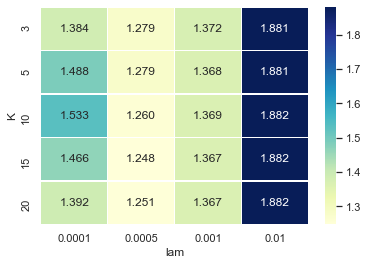

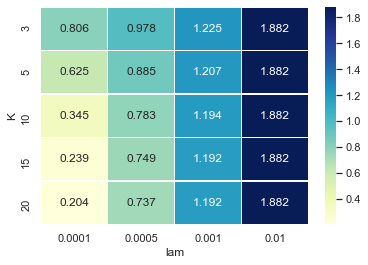

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.701 RMSE: 1.284
Reg-LFM: ite: 1; diff: 0.292 RMSE: 0.909
Reg-LFM: ite: 2; diff: 0.048 RMSE: 0.865
Reg-LFM: ite: 3; diff: 0.028 RMSE: 0.841
Reg-LFM: ite: 4; diff: 0.018 RMSE: 0.826
Reg-LFM: ite: 5; diff: 0.012 RMSE: 0.816
Reg-LFM: ite: 6; diff: 0.008 RMSE: 0.809
Reg-LFM: ite: 7; diff: 0.006 RMSE: 0.804
Reg-LFM: ite: 8; diff: 0.004 RMSE: 0.801
Reg-LFM: ite: 9; diff: 0.003 RMSE: 0.798


In [100]:
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pair)

# fit GLB + user_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [101]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_user_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 5.233236337113196
  item   rating
4BC7F1 6.623828
E36CD5 6.325177
604A4B 5.233236
F89A64 2.672779
A98D40 2.168624


GLB_item_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.929, valid_rmse: 1.660
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.908, valid_rmse: 1.619
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.917, valid_rmse: 1.692
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.996, valid_rmse: 2.272
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.928, valid_rmse: 1.707
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.113, valid_rmse: 1.557
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.107, valid_rmse: 1.587
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.102, valid_rmse: 1.591
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.109, valid_rmse: 1.606
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.094, valid_rmse: 1.499
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.349, valid_rmse: 1.649
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.343, valid_rmse: 1.647
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.340, valid_rmse: 1.670
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.337, valid_rmse: 1.661
5-Fold

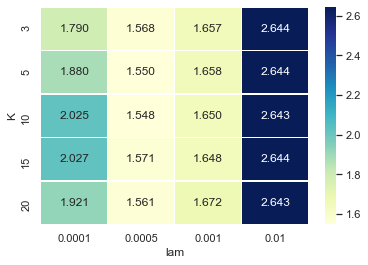

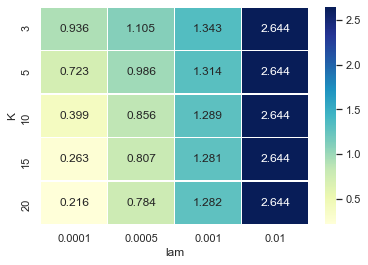

Fitting Reg-LFM: K: 10, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.612 RMSE: 1.574
Reg-LFM: ite: 1; diff: 0.315 RMSE: 1.078
Reg-LFM: ite: 2; diff: 0.057 RMSE: 1.017
Reg-LFM: ite: 3; diff: 0.034 RMSE: 0.982
Reg-LFM: ite: 4; diff: 0.024 RMSE: 0.959
Reg-LFM: ite: 5; diff: 0.017 RMSE: 0.943
Reg-LFM: ite: 6; diff: 0.013 RMSE: 0.931
Reg-LFM: ite: 7; diff: 0.010 RMSE: 0.922
Reg-LFM: ite: 8; diff: 0.008 RMSE: 0.915
Reg-LFM: ite: 9; diff: 0.006 RMSE: 0.909


In [102]:
## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
pred_item_mean = pred_glb + item_ave.predict(test_pair)

# fit GLB + item_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [103]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_item_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 4.070218075329894
  item   rating
90EC84 5.325922
E36CD5 4.717599
604A4B 4.070218
A98D40 1.810112
F89A64 1.551450


user_item_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.791, valid_rmse: 1.375
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.805, valid_rmse: 1.356
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.806, valid_rmse: 1.288
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.796, valid_rmse: 1.300
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.800, valid_rmse: 1.287
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.924, valid_rmse: 1.116
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.919, valid_rmse: 1.128
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.919, valid_rmse: 1.141
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.922, valid_rmse: 1.080
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.934, valid_rmse: 1.137
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.100, valid_rmse: 1.135
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.095, valid_rmse: 1.131
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.104, valid_rmse: 1.162
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.100, valid_rmse: 1.142
5-Fold

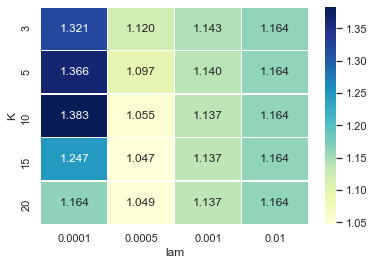

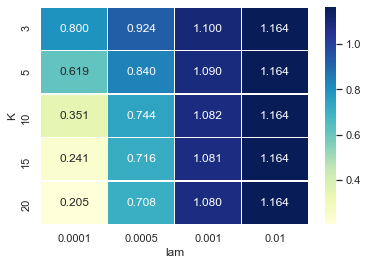

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.757 RMSE: 0.999
Reg-LFM: ite: 1; diff: 0.099 RMSE: 0.900
Reg-LFM: ite: 2; diff: 0.073 RMSE: 0.835
Reg-LFM: ite: 3; diff: 0.038 RMSE: 0.803
Reg-LFM: ite: 4; diff: 0.021 RMSE: 0.786
Reg-LFM: ite: 5; diff: 0.013 RMSE: 0.776
Reg-LFM: ite: 6; diff: 0.008 RMSE: 0.770
Reg-LFM: ite: 7; diff: 0.005 RMSE: 0.766
Reg-LFM: ite: 8; diff: 0.004 RMSE: 0.763
Reg-LFM: ite: 9; diff: 0.002 RMSE: 0.761


In [29]:
## user_mean + item mean + LFM
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [30]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('user_item_mean_LFM.csv', index=False)

## RMSE=1.149

test_pair: ['D7F746' 'E36CD5']
pred_rating: 4.322248330704945
  item   rating
604A4B 6.596046
A98D40 5.703949
F89A64 5.622304
E36CD5 4.322248
4BC7F1 3.156576


item_user_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.870, valid_rmse: 1.502
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.394
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.856, valid_rmse: 1.493
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.873, valid_rmse: 1.438
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.402
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.997, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.989, valid_rmse: 1.269
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.995, valid_rmse: 1.208
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.001, valid_rmse: 1.217
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.005, valid_rmse: 1.232
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.186, valid_rmse: 1.243
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.186, valid_rmse: 1.237
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.275
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.250
5-Fold

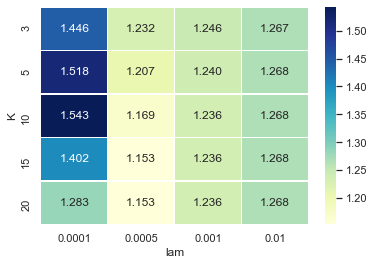

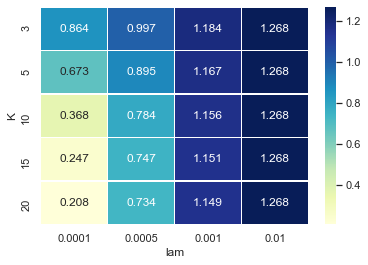

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.739 RMSE: 1.063
Reg-LFM: ite: 1; diff: 0.105 RMSE: 0.951
Reg-LFM: ite: 2; diff: 0.071 RMSE: 0.884
Reg-LFM: ite: 3; diff: 0.040 RMSE: 0.849
Reg-LFM: ite: 4; diff: 0.023 RMSE: 0.829
Reg-LFM: ite: 5; diff: 0.015 RMSE: 0.817
Reg-LFM: ite: 6; diff: 0.010 RMSE: 0.809
Reg-LFM: ite: 7; diff: 0.007 RMSE: 0.803
Reg-LFM: ite: 8; diff: 0.005 RMSE: 0.798
Reg-LFM: ite: 9; diff: 0.004 RMSE: 0.796


In [8]:
## item mean + user_mean + LFM
## item_mean 
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = item_ave.predict(test_pair)

## user_mean
train_rating_cm = train_rating - item_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [9]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('item_user_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 3.699872847611943
  item   rating
4BC7F1 6.904534
E36CD5 5.675935
604A4B 3.699873
A98D40 3.223570
F89A64 2.013034


GLB_item_user_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.864, valid_rmse: 1.443
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.866, valid_rmse: 1.423
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.488
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.860, valid_rmse: 1.453
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.864, valid_rmse: 1.417
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.994, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.988, valid_rmse: 1.224
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.997, valid_rmse: 1.260
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.012, valid_rmse: 1.258
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.002, valid_rmse: 1.231
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.179, valid_rmse: 1.255
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.176, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.239
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.176, valid_rmse: 1.256
5-Fold

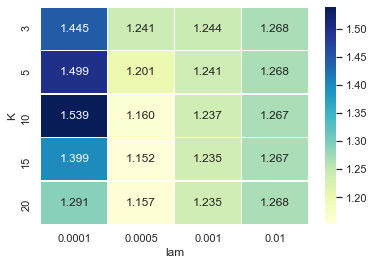

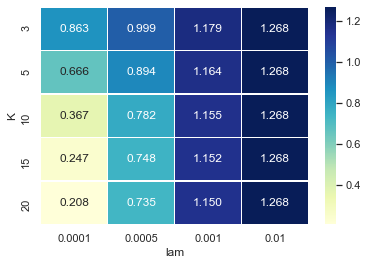

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.742 RMSE: 1.056
Reg-LFM: ite: 1; diff: 0.104 RMSE: 0.946
Reg-LFM: ite: 2; diff: 0.071 RMSE: 0.879
Reg-LFM: ite: 3; diff: 0.039 RMSE: 0.844
Reg-LFM: ite: 4; diff: 0.023 RMSE: 0.825
Reg-LFM: ite: 5; diff: 0.015 RMSE: 0.812
Reg-LFM: ite: 6; diff: 0.010 RMSE: 0.804
Reg-LFM: ite: 7; diff: 0.006 RMSE: 0.799
Reg-LFM: ite: 8; diff: 0.004 RMSE: 0.796
Reg-LFM: ite: 9; diff: 0.003 RMSE: 0.793


In [108]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# item_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pair)

# user_mean
train_rating_res -= item_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
train_rating_res -= user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [109]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_item_user_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 3.721348496876555
  item   rating
4BC7F1 6.914685
E36CD5 5.597167
604A4B 3.721348
A98D40 3.112566
F89A64 1.986474


GLB_user_item_mean_LMF

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.812, valid_rmse: 1.415
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.803, valid_rmse: 1.341
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.809, valid_rmse: 1.330
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.813, valid_rmse: 1.407
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.793, valid_rmse: 1.358
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.972, valid_rmse: 1.271
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.973, valid_rmse: 1.291
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.980, valid_rmse: 1.263
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.969, valid_rmse: 1.260
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.965, valid_rmse: 1.298
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.215, valid_rmse: 1.389
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.230, valid_rmse: 1.320
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.231, valid_rmse: 1.354
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.220, valid_rmse: 1.407
5-Fold

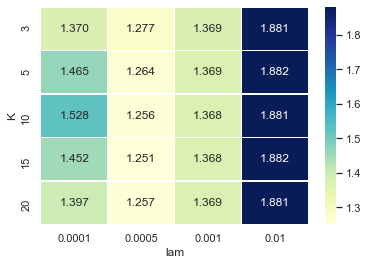

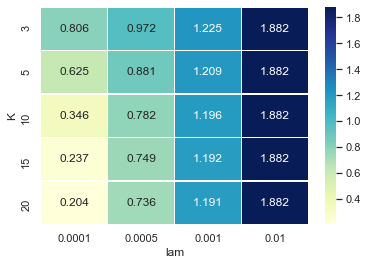

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.704 RMSE: 1.291
Reg-LFM: ite: 1; diff: 0.290 RMSE: 0.917
Reg-LFM: ite: 2; diff: 0.046 RMSE: 0.875
Reg-LFM: ite: 3; diff: 0.029 RMSE: 0.850
Reg-LFM: ite: 4; diff: 0.021 RMSE: 0.832
Reg-LFM: ite: 5; diff: 0.014 RMSE: 0.820
Reg-LFM: ite: 6; diff: 0.009 RMSE: 0.813
Reg-LFM: ite: 7; diff: 0.007 RMSE: 0.807
Reg-LFM: ite: 8; diff: 0.005 RMSE: 0.803
Reg-LFM: ite: 9; diff: 0.004 RMSE: 0.800


In [31]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pair)

# item_mean
train_rating_res -=  user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pair)


# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

In [32]:
## print T-th record and top-5 preferred items
print_T(2095,temp_test_pair,pred_rating)
print_top5(2095,temp_test_pair,pred_rating)

# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_user_item_mean_LFM.csv', index=False)

test_pair: ['D7F746' 'E36CD5']
pred_rating: 4.782893392498797
  item   rating
604A4B 8.152251
A98D40 6.855999
F89A64 6.714650
E36CD5 4.782893
4BC7F1 2.519099


In [ ]:
### Note2: the computation complexity is not relative large for `augmentation step`, yet it might be solved by `SGD`.

In [198]:
class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for j in range(n_obs):
                user_id, item_id, rating_tmp = train_pair[j,0], train_pair[j,1], train_rating[j]
                err_tmp = rating_tmp - np.dot(self.P[user_id,:], self.Q[item_id,:])
                self.Q[item_id,:] = self.Q[item_id,:] + 2*learning_rate*err_tmp*self.P[user_id,:] - 2*learning_rate*lam*self.Q[item_id,:]
                err_tmp = rating_tmp - np.dot(self.P[user_id,:], self.Q[item_id,:])
                self.P[user_id,:] = self.P[user_id,:] + 2*learning_rate*self.Q[item_id,:] - 2*learning_rate*lam*self.P[user_id,:]
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - score_new + score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [194]:
## Baseline + LFM
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating_cm - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

## refit the best model, and make prediction
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair=train_pair, train_rating=train_rating_res, learning_rate=.001)
pred = pred + shiing.predict(test_pair)


Fitting Reg-LFM: K: 20, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.353 RMSE: 4.167
Reg-LFM: ite: 1; diff: 0.306 RMSE: 3.862
Reg-LFM: ite: 2; diff: 0.267 RMSE: 3.595
Reg-LFM: ite: 3; diff: 0.233 RMSE: 3.362
Reg-LFM: ite: 4; diff: 0.205 RMSE: 3.156
Reg-LFM: ite: 5; diff: 0.181 RMSE: 2.975
Reg-LFM: ite: 6; diff: 0.161 RMSE: 2.814
Reg-LFM: ite: 7; diff: 0.143 RMSE: 2.670
Reg-LFM: ite: 8; diff: 0.128 RMSE: 2.542
Reg-LFM: ite: 9; diff: 0.115 RMSE: 2.427
Reg-LFM: ite: 10; diff: 0.104 RMSE: 2.323
Reg-LFM: ite: 11; diff: 0.094 RMSE: 2.229
Reg-LFM: ite: 12; diff: 0.085 RMSE: 2.143
Reg-LFM: ite: 13; diff: 0.078 RMSE: 2.065
Reg-LFM: ite: 14; diff: 0.071 RMSE: 1.994
Reg-LFM: ite: 15; diff: 0.065 RMSE: 1.929
Reg-LFM: ite: 16; diff: 0.060 RMSE: 1.869
Reg-LFM: ite: 17; diff: 0.055 RMSE: 1.814
Reg-LFM: ite: 18; diff: 0.051 RMSE: 1.763
Reg-LFM: ite: 19; diff: 0.047 RMSE: 1.715
Reg-LFM: ite: 20; diff: 0.044 RMSE: 1.671
Reg-LFM: ite: 21; diff: 0.041 RMSE: 1.631
Reg-LFM: ite: 22; diff: 0.038 RMSE: 1.593
Reg-LFM

Reg-LFM: ite: 193; diff: 0.001 RMSE: 0.729
Reg-LFM: ite: 194; diff: 0.001 RMSE: 0.728
Reg-LFM: ite: 195; diff: 0.001 RMSE: 0.728
Reg-LFM: ite: 196; diff: 0.001 RMSE: 0.727
Reg-LFM: ite: 197; diff: 0.001 RMSE: 0.727
Reg-LFM: ite: 198; diff: 0.001 RMSE: 0.726
Reg-LFM: ite: 199; diff: 0.001 RMSE: 0.725
Reg-LFM: ite: 200; diff: 0.001 RMSE: 0.725
Reg-LFM: ite: 201; diff: 0.001 RMSE: 0.724
Reg-LFM: ite: 202; diff: 0.001 RMSE: 0.724
Reg-LFM: ite: 203; diff: 0.001 RMSE: 0.723
Reg-LFM: ite: 204; diff: 0.001 RMSE: 0.723
Reg-LFM: ite: 205; diff: 0.001 RMSE: 0.722
Reg-LFM: ite: 206; diff: 0.001 RMSE: 0.722
Reg-LFM: ite: 207; diff: 0.001 RMSE: 0.721
Reg-LFM: ite: 208; diff: 0.001 RMSE: 0.720
Reg-LFM: ite: 209; diff: 0.001 RMSE: 0.720
Reg-LFM: ite: 210; diff: 0.001 RMSE: 0.719
Reg-LFM: ite: 211; diff: 0.001 RMSE: 0.719
Reg-LFM: ite: 212; diff: 0.001 RMSE: 0.718
Reg-LFM: ite: 213; diff: 0.001 RMSE: 0.718
Reg-LFM: ite: 214; diff: 0.001 RMSE: 0.717
Reg-LFM: ite: 215; diff: 0.001 RMSE: 0.717
Reg-LFM: it

Reg-LFM: ite: 384; diff: 0.000 RMSE: 0.657
Reg-LFM: ite: 385; diff: 0.000 RMSE: 0.657
Reg-LFM: ite: 386; diff: 0.000 RMSE: 0.656
Reg-LFM: ite: 387; diff: 0.000 RMSE: 0.656
Reg-LFM: ite: 388; diff: 0.000 RMSE: 0.656
Reg-LFM: ite: 389; diff: 0.000 RMSE: 0.656
Reg-LFM: ite: 390; diff: 0.000 RMSE: 0.656
Reg-LFM: ite: 391; diff: 0.000 RMSE: 0.656
Reg-LFM: ite: 392; diff: 0.000 RMSE: 0.656
Reg-LFM: ite: 393; diff: 0.000 RMSE: 0.656


In [195]:
# Make your prediction
# pred_rating is an array of your prediction for `dtest`
pred_rating = pred


# submission
sub['rating'] = pred_rating
sub.to_csv('GLB_user_item_mean_LFMSGD.csv', index=False)

## Then just submit sub1.csv to the competition in Kaggle


In [199]:
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)
## refit the best model, and make prediction

shiing=LFM(n_user, n_item, K=3, lam=best_lam)
shiing.fit(train_pair=train_pair, train_rating=train_rating_res, learning_rate=.001)
pred = pred + shiing.predict(test_pair)


Fitting Reg-LFM: K: 3, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.086 RMSE: 2.075
Reg-LFM: ite: 1; diff: 0.078 RMSE: 1.997
Reg-LFM: ite: 2; diff: 0.071 RMSE: 1.926
Reg-LFM: ite: 3; diff: 0.065 RMSE: 1.861
Reg-LFM: ite: 4; diff: 0.059 RMSE: 1.802
Reg-LFM: ite: 5; diff: 0.054 RMSE: 1.749
Reg-LFM: ite: 6; diff: 0.049 RMSE: 1.700
Reg-LFM: ite: 7; diff: 0.045 RMSE: 1.655
Reg-LFM: ite: 8; diff: 0.041 RMSE: 1.614
Reg-LFM: ite: 9; diff: 0.037 RMSE: 1.577
Reg-LFM: ite: 10; diff: 0.034 RMSE: 1.543
Reg-LFM: ite: 11; diff: 0.031 RMSE: 1.512
Reg-LFM: ite: 12; diff: 0.029 RMSE: 1.483
Reg-LFM: ite: 13; diff: 0.026 RMSE: 1.456
Reg-LFM: ite: 14; diff: 0.024 RMSE: 1.432
Reg-LFM: ite: 15; diff: 0.022 RMSE: 1.410
Reg-LFM: ite: 16; diff: 0.021 RMSE: 1.389
Reg-LFM: ite: 17; diff: 0.019 RMSE: 1.370
Reg-LFM: ite: 18; diff: 0.018 RMSE: 1.352
Reg-LFM: ite: 19; diff: 0.016 RMSE: 1.336
Reg-LFM: ite: 20; diff: 0.015 RMSE: 1.321
Reg-LFM: ite: 21; diff: 0.014 RMSE: 1.307
Reg-LFM: ite: 22; diff: 0.013 RMSE: 1.294
Reg-LFM:

In [200]:
# Make your prediction
# pred_rating is an array of your prediction for `dtest`
pred_rating = pred


# submission
sub['rating'] = pred_rating
sub.to_csv('user_item_mean_LFMSGD.csv', index=False)

## Then just submit sub1.csv to the competition in Kaggle

In [13]:
pred

array([12.73030964, 17.99001373, 17.29738727, ..., 15.02221017,
       23.32010652, 19.27083655])

In [24]:
t=2095
print_T(2095,temp_test_pair,pred_rating)
user_index=np.where(temp_test_pair[:,0]==temp_test_pair[t,0])[0]
item_index=pred_rating[user_index].argsort()[-5:][::-1]
list1=temp_test_pair[user_index,1][item_index]
list2=pred_rating[user_index][item_index]
result = pd.DataFrame(list(zip(list1, list2)), columns =['item', 'rating'])
print(result.sort_values(by='rating', ascending=False).to_string(index=False))


test_pair: ['D7F746' 'E36CD5']
pred_rating: 3.699872847611943
  item   rating
604A4B 6.904534
A98D40 5.806089
F89A64 5.675935
E36CD5 3.699873
4BC7F1 3.223570


In [22]:
user_index

array([2095, 2178, 2506, 2637, 3580, 3772], dtype=int64)

In [21]:
user_index[item_index]

array([3580, 3772, 2637, 2095, 2178], dtype=int64)

In [19]:
pred_rating[user_index].argsort()[-5:][::-1]

array([4, 5, 3, 0, 1], dtype=int64)

In [17]:
pred_rating[item_index]

array([4.38864445, 3.8147658 , 4.47341606, 2.59799852, 5.33317706])